### Load the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Loading
file_path = '/content/family_financial_and_transactions_data.xlsx'

# Load the data from the Excel sheet
df = pd.read_excel(file_path, sheet_name='final_family_financial_and_tran')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16306 entries, 0 to 16305
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Family ID                16306 non-null  object        
 1   Member ID                16306 non-null  object        
 2   Transaction Date         16306 non-null  datetime64[ns]
 3   Category                 16306 non-null  object        
 4   Amount                   16306 non-null  float64       
 5   Income                   16306 non-null  int64         
 6   Savings                  16306 non-null  int64         
 7   Monthly Expenses         16306 non-null  int64         
 8   Loan Payments            16306 non-null  int64         
 9   Credit Card Spending     16306 non-null  int64         
 10  Dependents               16306 non-null  int64         
 11  Financial Goals Met (%)  16306 non-null  int64         
dtypes: datetime64[ns](1), float64(1)

###Explore the data

In [3]:
df.head()

,Family ID,Member ID,Transaction Date,Category,Amount,Income,Savings,Monthly Expenses,Loan Payments,Credit Card Spending,Dependents,Financial Goals Met (%)
0,FAM001,FAM001_Member1,2024-10-07,Travel,409.12,113810,20234,5781,2422,2959,2,68
1,FAM001,FAM001_Member1,2024-10-16,Travel,270.91,113810,20234,5781,2422,2959,2,68
2,FAM001,FAM001_Member1,2024-10-17,Groceries,91.10,113810,20234,5781,2422,2959,2,68
3,FAM001,FAM001_Member1,2024-10-25,Healthcare,198.23,113810,20234,5781,2422,2959,2,68
4,FAM001,FAM001_Member1,2024-10-25,Education,206.42,113810,20234,5781,2422,2959,2,68


In [6]:
# Checking for missing values
missing_values = df.isnull().sum()

In [7]:
# Dropping rows with missing data (if applicable)
data_cleaned = df.dropna()

In [8]:
# Converting dates to datetime format for better manipulation
data_cleaned["Transaction Date"] = pd.to_datetime(data_cleaned["Transaction Date"])

### Exploratory Data Analysis (EDA)


In [9]:
# Spending Distribution Across Categories
category_spending = data_cleaned.groupby("Category")["Amount"].sum().sort_values(ascending=False)


<ipython-input-10-6a17f4e810ad>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_spending.index, y=category_spending.values, palette="viridis")


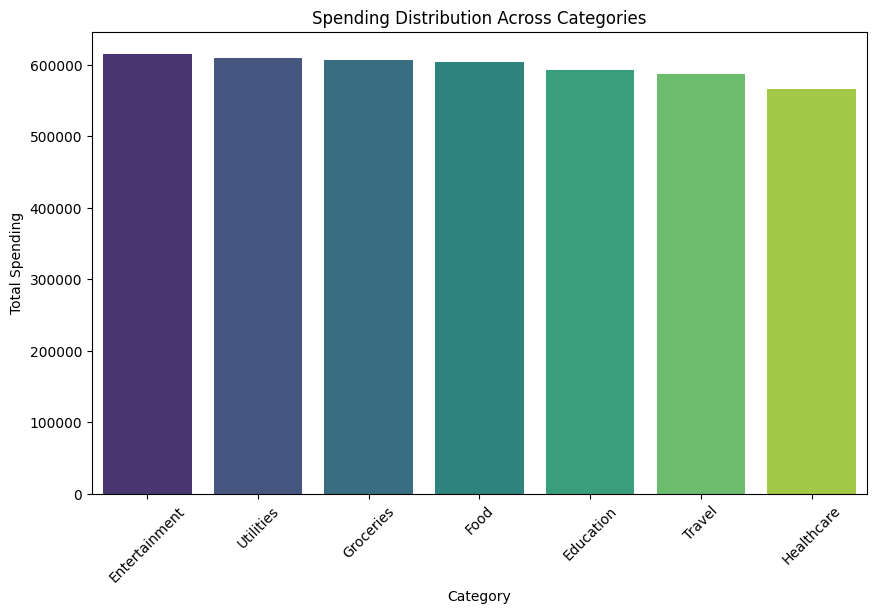

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=category_spending.index, y=category_spending.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Spending Distribution Across Categories")
plt.ylabel("Total Spending")
plt.xlabel("Category")
plt.show()

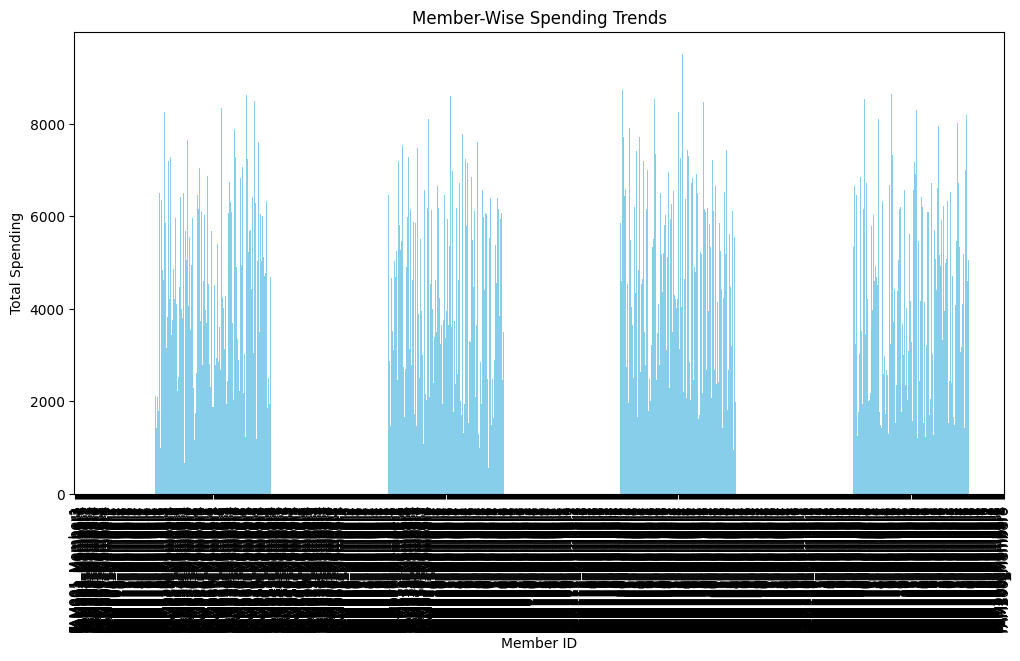

In [11]:
#Member-Wise Spending Trends
member_spending = data_cleaned.groupby("Member ID")["Amount"].sum()

plt.figure(figsize=(12, 6))
member_spending.plot(kind="bar", color="skyblue")
plt.title("Member-Wise Spending Trends")
plt.ylabel("Total Spending")
plt.xlabel("Member ID")
plt.show()

### Feature Engineering


In [12]:
# Calculating Savings-to-Income Ratio
data_cleaned["Savings_to_Income_Ratio"] = data_cleaned["Savings"] / data_cleaned["Income"]

In [13]:
# Calculating Monthly Expenses as a Percentage of Income
data_cleaned["Expenses_Percentage"] = data_cleaned["Monthly Expenses"] / data_cleaned["Income"]

In [14]:
# Calculating Loan Payments as a Percentage of Income
data_cleaned["Loan_Payments_Percentage"] = data_cleaned["Loan Payments"] / data_cleaned["Income"]

In [15]:
# Adding Category-Wise Spending Distribution
category_spending_distribution = data_cleaned.pivot_table(values="Amount",
                                                          index="Family ID",
                                                          columns="Category",
                                                          aggfunc="sum",
                                                          fill_value=0)

In [16]:
# Merging with the main dataset
data_with_features = pd.merge(data_cleaned, category_spending_distribution, on="Family ID", how="left")

###Scoring Model Implementation

In [17]:
# Define the scoring logic
def calculate_financial_score(row):
    score = 100
    # Penalize low Savings-to-Income Ratio
    if row["Savings_to_Income_Ratio"] < 0.2:
        score -= 20
    elif row["Savings_to_Income_Ratio"] < 0.5:
        score -= 10

    # Penalize high Monthly Expenses as Percentage of Income
    if row["Expenses_Percentage"] > 0.8:
        score -= 25
    elif row["Expenses_Percentage"] > 0.5:
        score -= 15

    # Penalize high Loan Payments as Percentage of Income
    if row["Loan_Payments_Percentage"] > 0.4:
        score -= 20
    elif row["Loan_Payments_Percentage"] > 0.2:
        score -= 10

    # Penalize excessive spending in discretionary categories
    if row.get("Travel", 0) / row["Income"] > 0.1:
        score -= 10
    if row.get("Entertainment", 0) / row["Income"] > 0.1:
        score -= 10

    # Reward for achieving financial goals
    if row["Financial Goals Met (%)"] > 80:
        score += 10
    elif row["Financial Goals Met (%)"] > 50:
        score += 5

    return max(0, score)  # Ensure score is not negative

In [18]:
# Apply the scoring function
data_with_features["Financial_Score"] = data_with_features.apply(calculate_financial_score, axis=1)

# Display the updated dataset with scores
print(data_with_features[["Family ID", "Financial_Score"]].head())

  Family ID  Financial_Score
0    FAM001               85
1    FAM001               85
2    FAM001               85
3    FAM001               85
4    FAM001               85


###Insights Visualization

<ipython-input-19-56e5f59d0e0b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_with_features, x="Family ID", y="Financial_Score", palette="coolwarm")


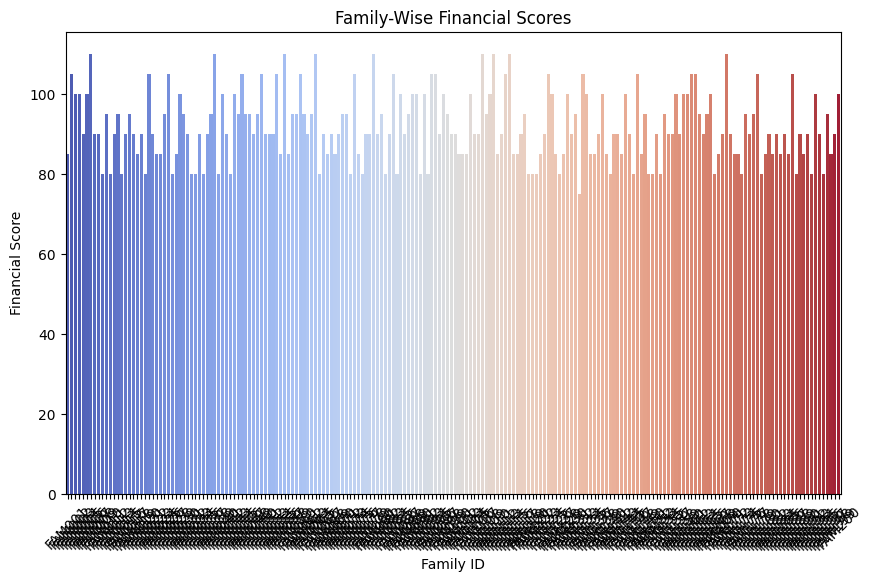

In [19]:
# Family-Wise Financial Scores
plt.figure(figsize=(10, 6))
sns.barplot(data=data_with_features, x="Family ID", y="Financial_Score", palette="coolwarm")
plt.title("Family-Wise Financial Scores")
plt.xticks(rotation=45)
plt.ylabel("Financial Score")
plt.xlabel("Family ID")
plt.show()

Spending Distribution: Bar chart showing spending across categories.

Member-Wise Trends: Bar chart for spending trends per member.

Family-Wise Financial Scores: Visualization of financial health scores for familie